In [183]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [184]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
def reynolds_number(flow_velocity, pipe_diameter, TK=298.15,
                    kinematic_viscosity = None): #Dimensionless
    """
        Calculates Reynolds number of water from velocity and diameter
    """
    kinematic_viscosity = kinematic_viscosity or pyequion2.water_properties.water_kinematic_viscosity(TK)
    return flow_velocity*pipe_diameter/kinematic_viscosity


def darcy_friction_factor(flow_velocity=float,
                          pipe_diameter=float,
                          TK=298.15,
                          kinematic_viscosity=None):
    reynolds = reynolds_number(flow_velocity, pipe_diameter, TK, kinematic_viscosity)
    if reynolds < 2300:
        return 64/reynolds
    else: #Blasius
        return 0.316*reynolds**(-1./4)
    

def get_shear_velocity(flow_velocity,
                   pipe_diameter,
                   TK=298.15,
                   kinematic_viscosity=None):
    f = darcy_friction_factor(flow_velocity, pipe_diameter, TK, kinematic_viscosity)
    return np.sqrt(f/8.0)*flow_velocity

In [214]:
eqsys = pyequion2.EquilibriumBackend(["C", "Ca", "Mg"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")
eqsys_front = pyequion2.EquilibriumSystem(["C", "Ca", "Mg"], from_elements=True,
                                           activity_model="DEBYE")

In [242]:
TK = 298.15
bulk_velocity = 1.0
pipe_diameter = 1e-2
shear_velocity = get_shear_velocity(bulk_velocity, pipe_diameter, TK)
kinematic_viscosity = 1e-6
molal_balance = {'C':0.065*1e-1, 'Ca':0.028*1e-1, 'Mg':1e-4*3}
molal_balance = {k:v*1e0 for k, v in molal_balance.items()}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Calcite"],
                           kreaction="inf")
builder.make_grid(20, 5)
builder.set_species()

In [243]:
sol, _ = eqsys_front.solve_equilibrium_mixed_balance(TK, molal_balance=molal_balance)
sol.saturation_indexes

{'Aragonite': 0.5290474941622456,
 'Calcite': 0.6728173415544809,
 'Dolomite': 0.5093724006497666,
 'Vaterite': 0.10638584734018153}

In [244]:
builder.set_initial_guess_from_bulk()
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);

In [245]:
def f(t, x):
    builder.cbulk = {el:x[i] for i, el in enumerate(builder.eqsys.solute_elements)}
#     solsimple = builder.solve_lma(simplified=True);
    solfull = builder.solve_lma(simplified=False);
    res = builder.fluxes().detach().numpy()[:-1, -1]*4/pipe_diameter
    return res

In [246]:
x = np.array([molal_balance[el] for el in builder.eqsys.solute_elements])

In [247]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success, solfull.success

(True, True)

In [248]:
solver = scipy.integrate.ode(f)
solver.set_integrator("vode")
solver.set_initial_value(x)
xarr = [x.copy()]
tarr = [0.0]
tmax = 100.0
while solver.successful():
    solver.integrate(tmax, step=True)
    xarr.append(solver.y)
    tarr.append(solver.t)
    if solver.t > tmax:
        break
    print(solver.t, solver.y)

1.830270074678971e-05 [0.00649975 0.00279975 0.0003    ]
0.00021486729269788385 [0.00649702 0.00279702 0.0003    ]
0.00021757398192560516 [0.00649698 0.00279698 0.0003    ]
0.00022028067115332646 [0.00649695 0.00279695 0.0003    ]
0.0002473475634305394 [0.00649658 0.00279658 0.0003    ]
0.0005180164862026689 [0.00649289 0.00279289 0.00030001]
0.000522240191373235 [0.00649283 0.00279284 0.00030001]
0.000526463896543801 [0.00649278 0.00279278 0.00030001]
0.0005687009482494618 [0.00649221 0.00279221 0.00030001]
0.0009910714653060698 [0.00648655 0.00278656 0.00030003]
0.0009968384792489202 [0.00648647 0.00278648 0.00030003]
0.0010026054931917706 [0.0064864  0.0027864  0.00030003]
0.0010602756326202752 [0.00648563 0.00278563 0.00030003]
0.0016369770269053226 [0.00647795 0.00277795 0.00030003]
0.001665812096619575 [0.00647757 0.00277757 0.00030004]
0.0016946471663338274 [0.00647718 0.00277719 0.00030004]
0.001982997863476351 [0.00647337 0.00277339 0.00030004]
0.0019865301726003886 [0.0064733

0.036878993065788415 [0.00615783 0.00245875 0.00030302]
0.036893789697004215 [0.00615775 0.00245867 0.00030302]
0.036908586328220014 [0.00615767 0.0024586  0.00030303]
0.03705655264037798 [0.00615688 0.00245782 0.00030305]
0.038536215761957655 [0.006149   0.00245001 0.00030331]
0.038551012393173455 [0.00614892 0.00244994 0.00030331]
0.038565809024389254 [0.00614885 0.00244986 0.00030331]
0.03871377533654722 [0.00614814 0.00244915 0.00030333]
0.040193438458126896 [0.006141   0.00244202 0.00030353]
0.040208235089342695 [0.00614093 0.00244195 0.00030353]
0.040223031720558494 [0.00614086 0.00244188 0.00030353]
0.04037099803271646 [0.00614018 0.0024412  0.00030354]
0.041850661154296136 [0.0061334  0.00243437 0.00030364]
0.04185454167986006 [0.00613338 0.00243435 0.00030364]
0.04185842220542398 [0.00613336 0.00243434 0.00030364]
0.0418972274610632 [0.00613318 0.00243415 0.00030365]
0.04228528001745532 [0.00613135 0.00243233 0.00030366]
0.04616580558137658 [0.00611311 0.00241406 0.00030376]
0

0.5345030732022744 [0.00586926 0.00216718 0.0003154 ]
0.5345106424596464 [0.00586925 0.00216718 0.0003154 ]
0.5345863350333667 [0.0058692  0.00216713 0.00031542]
0.5353432607705698 [0.00586873 0.00216668 0.0003156 ]
0.5429125181426011 [0.00586404 0.00216216 0.00031738]
0.5429314412860312 [0.00586403 0.00216215 0.00031738]
0.5429503644294613 [0.00586403 0.00216215 0.00031739]
0.5431395958637621 [0.00586398 0.0021621  0.00031741]
0.54503191020677 [0.00586346 0.00216162 0.00031771]
0.5639550536368483 [0.00585833 0.00215682 0.00032061]
0.563966880601492 [0.00585833 0.00215682 0.00032061]
0.5639787075661358 [0.00585833 0.00215682 0.00032062]
0.5640969772125738 [0.00585832 0.00215683 0.00032063]
0.5652796736769536 [0.00585828 0.00215686 0.00032073]
0.5771066383207526 [0.00585785 0.00215716 0.00032174]
0.6953762847587417 [0.00585358 0.00216016 0.00033192]
0.6953774397357577 [0.00585358 0.00216016 0.00033192]
0.6953785947127737 [0.00585358 0.00216016 0.00033192]
0.6953901444829337 [0.0058536  

1.4658739683509254 [0.00599038 0.00228403 0.00026454]
1.4658869721166012 [0.00599038 0.00228403 0.00026454]
1.465899975882277 [0.00599038 0.00228403 0.00026454]
1.4660300135390356 [0.00599037 0.00228402 0.00026452]
1.467330390106621 [0.00599027 0.00228391 0.00026435]
1.4803341557824754 [0.00598927 0.0022829  0.00026266]
1.480464193439234 [0.00598928 0.0022829  0.00026265]
1.4805942310959925 [0.00598928 0.00228289 0.00026263]
1.481894607663578 [0.00598933 0.00228282 0.00026247]
1.4948983733394323 [0.00598982 0.00228212 0.00026084]
1.624936030097977 [0.0059947  0.00227512 0.00024458]
1.6249373058753773 [0.0059947  0.00227512 0.00024458]
1.6249385816527777 [0.0059947  0.00227512 0.00024458]
1.6249513394267807 [0.00599471 0.00227513 0.00024458]
1.6250789171668107 [0.00599481 0.00227523 0.00024457]
1.6263546945671103 [0.00599588 0.00227627 0.00024447]
1.6391124685701064 [0.00600651 0.00228661 0.00024351]
1.6391204421788583 [0.00600652 0.00228661 0.00024351]
1.6391284157876103 [0.00600652 0.

2.1587091808334256 [0.00617411 0.00244842 0.00012904]
2.16049263609137 [0.00617378 0.00244806 0.00012902]
2.178327188670812 [0.00617042 0.00244448 0.00012882]
2.178371775052261 [0.0061704  0.00244447 0.00012882]
2.1784163614337095 [0.00617039 0.00244445 0.00012882]
2.1788622252481957 [0.00617023 0.00244428 0.00012884]
2.1833208633930563 [0.00616868 0.00244258 0.00012904]
2.227907244841662 [0.00615319 0.00242558 0.000131  ]
2.2279142114637636 [0.0061532  0.00242559 0.000131  ]
2.227921178085865 [0.0061532  0.00242559 0.000131  ]
2.2279908443068783 [0.00615323 0.00242562 0.00013099]
2.2286875065170126 [0.00615357 0.00242597 0.00013087]
2.235654128618357 [0.0061569  0.00242945 0.0001297 ]
2.2356715451736107 [0.0061569  0.00242945 0.0001297 ]
2.235688961728864 [0.00615691 0.00242946 0.0001297 ]
2.235863127281398 [0.00615697 0.00242952 0.00012968]
2.2376047828067342 [0.00615761 0.00243016 0.00012949]
2.255021338060096 [0.00616394 0.0024365  0.0001276 ]
2.2550322234071296 [0.00616394 0.00243

2.769376503381519 [6.28874399e-03 2.57658508e-03 4.57202263e-05]
2.808049024685396 [6.29125700e-03 2.57948605e-03 4.20538056e-05]
2.808073195011211 [6.29125631e-03 2.57948531e-03 4.20516504e-05]
2.808097365337026 [6.29125562e-03 2.57948458e-03 4.20494951e-05]
2.8083390685951755 [6.29124875e-03 2.57947725e-03 4.20279429e-05]
2.810756101176668 [6.29118005e-03 2.57940394e-03 4.18124208e-05]
2.834926426991591 [6.29049303e-03 2.57867084e-03 3.96571993e-05]
3.0766296851408215 [6.28362281e-03 2.57133982e-03 1.81049849e-05]
3.076639126674343 [6.28361589e-03 2.57133284e-03 1.81069148e-05]
3.076648568207865 [6.28360897e-03 2.57132585e-03 1.81088446e-05]
3.0767429835430793 [6.28353975e-03 2.57125600e-03 1.81281429e-05]
3.0776871368952246 [6.28284758e-03 2.57055753e-03 1.83211254e-05]
3.087128670416679 [6.27592584e-03 2.56357279e-03 2.02509512e-05]
3.0871522742504824 [6.27591529e-03 2.56356258e-03 2.02547767e-05]
3.087175878084286 [6.27590473e-03 2.56355236e-03 2.02586021e-05]
3.0874119164223224 [

4.4306573137504675 [6.28436264e-03 2.56202202e-03 2.87226275e-05]
5.3735001664066075 [ 6.28365253e-03  2.57298020e-03 -1.07640333e-05]


capi_return is NULL
Call-back cb_f_in_dvode__user__routines failed.


KeyboardInterrupt: 

In [249]:
xarr = np.vstack(xarr)
tarr = np.array(tarr)

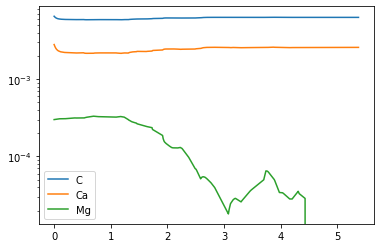

In [250]:
for i, el in enumerate(eqsys.solute_elements):
    plt.semilogy(tarr, xarr[:, i], label=el)
plt.legend()